In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
import lenstronomy.Plots.output_plots as lens_plot
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Plots.output_plots import LensModelPlot
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.image_util as image_util

In [3]:
#Lens Model
lens_model_list = ['SPEP']
lensModel = LensModel(lens_model_list=lens_model_list)
kwargs_spep = {'theta_E': .9, 'e1': 0.05, 'e2': 0.05, 'gamma': 2., 'center_x': 0, 'center_y': 0}
kwargs_lens = [kwargs_spep]
#All image positions & magnifications (beta is source position)
beta_ra, beta_dec = 0, 0 #Aligned with the lens 
solver = LensEquationSolver(lensModel)
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)
#Source light
source_light_model_list = ['SERSIC']
lightModel_source = LightModel(light_model_list=source_light_model_list)
kwargs_light_source = [{'amp': 5000, 'R_sersic': 0.02, 'n_sersic': 1.5, 'center_x': beta_ra, 'center_y': beta_dec}]
#Lens light
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list=lens_light_model_list)
e1, e2 = param_util.phi_q2_ellipticity(phi=0.5, q=0.7)
kwargs_light_lens = [{'amp': 100000, 'R_sersic': 0.1, 'n_sersic': 2.5, 'e1': e1, 'e2': e2, 'center_x': 0.1, 'center_y': 0}]
#Point source
point_source_model_list = ['LENSED_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[False])
kwargs_ps = [{'ra_image': theta_ra, 'dec_image': theta_dec, 'point_amp': np.abs(mag)*30}]
#Data 
deltaPix = 0.05 
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5 
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix 
kwargs_pixel = {'nx': 100, 'ny': 100, 'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
#PSF
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.1, 'pixel_size': deltaPix}
psf = PSF(**kwargs_psf)

In [4]:
#Image model
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=lightModel_source, lens_light_model_class=lightModel_lens,
                        point_source_class=pointSource, kwargs_numerics=kwargs_numerics)
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens, kwargs_ps=kwargs_ps)
#Noise
exp_time = 10 
background_rms = 0.1
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson
#Image data
kwargs_data = {'image_data': image_noisy, 'background_rms': background_rms, 'exposure_time': exp_time,
               'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 'transform_pix2angle': transform_pix2angle} 

reduced chi^2 =  0.814315491953


/global/u1/j/jimenago/StrongLensing/lenstronomy/lenstronomy/Plots/output_plots.py:320: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


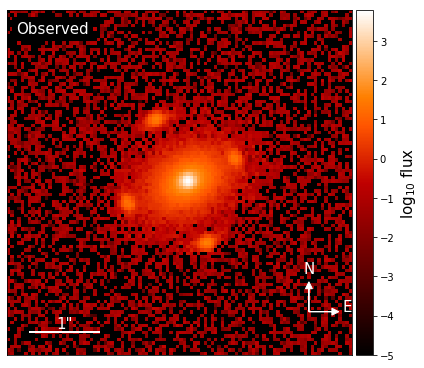

In [5]:
# illustrate fit
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_light_model_list,
               'lens_light_model_list': lens_light_model_list, 'point_source_model_list': point_source_model_list}
lensPlot = LensModelPlot(kwargs_data, kwargs_psf, kwargs_numerics, kwargs_model, kwargs_lens, kwargs_light_source,
                            kwargs_light_lens, kwargs_ps, arrow_size=0.02)
f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
lensPlot.data_plot(ax=axes)
f.tight_layout()
plt.show()